In [1]:
# === Bibliotecas padrão ===
from pathlib import Path
import importlib

# === Bibliotecas de terceiros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import compute_sample_weight

import joblib

# === Módulos locais ===
import sys
import os

# Caminho absoluto até a pasta src
src_path = r"C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\notebooks\src"

if src_path not in sys.path:
    sys.path.append(src_path)
    
# Garante que a pasta atual (notebooks/) esteja no sys.path
notebooks_dir = os.path.abspath(os.getcwd())
if notebooks_dir not in sys.path:
    sys.path.append(notebooks_dir)

# Agora importa diretamente SEM prefixo
import leadscore_plot
importlib.reload(leadscore_plot)

from leadscore_plot import (
    plot_comparativo_leads_alunos,
    plot_histograma_leadscore,
    plot_probabilidade_conversao_vs_score
)

# === Configuração de visualização ===
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
# === Imports
import gspread
from gspread_dataframe import get_as_dataframe
import os
from dotenv import load_dotenv
from google.oauth2 import service_account

# === Carregar variáveis de ambiente
load_dotenv()

# === Autenticação
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para carregar direto do Google Sheets
def carregar_aba(sheet_id, aba_nome="Dados"):
    planilha = client.open_by_key(sheet_id)
    aba = planilha.worksheet(aba_nome)
    df = pd.DataFrame(aba.get_all_records())
    return df

# === IDs fixos das suas planilhas
id_pesquisa_captacao = "1ukLwu8SoP0U3uirB6w1Ca3TPEITY50c558xNUUN3kj4"
id_pesquisa_aluno = "1GDCAa1fiflDIBnRY9rrdY9ghKwS6DPzxIG9FYGZEsQU"
id_invest_trafego = "1477LAemTkMN1YTFdRJkLMaDLPZEiJ3vvtqwduemHXD4"

# === Carregar os dados direto da nuvem
df_leads = carregar_aba(id_pesquisa_captacao)
df_alunos = carregar_aba(id_pesquisa_aluno)
df_invest_trafego = carregar_aba(id_invest_trafego)

# === Garantir cópias para segurança
df_leads = df_leads.copy()
df_alunos = df_alunos.copy()

# === Criar variável target 'comprou'
df_leads["comprou"] = df_leads["email"].isin(df_alunos["email"]).astype(int)

In [3]:
df_leads.drop(columns=['email']).head()

data  idade    nível  \
0  2025-04-07 0:00:00  38-45  Técnica   
1  2025-04-07 0:00:00  38-45  Técnica   
2  2025-04-07 0:00:00  28-32  Técnica   
3  2025-04-07 0:00:00  18-22  Técnica   
4  2025-04-07 0:00:00  23-27  Técnica   

                               situação profissional                  renda  \
0  Já sou funcionário terceirizado do sistema Pet...       De 3.000 a 5.000   
1                                    Desempregado(a)  Estou desempregado(a)   
2                                Funcionário público       De 1.000 a 3.000   
3                                    Desempregado(a)  Estou desempregado(a)   
4                                    Desempregado(a)       De 1.000 a 3.000   

             escolaridade                                 duvida  \
0  Nível técnico completo  Como participar do processo seletivo    
1  Nível técnico completo   Assunto específico que cai na prova?   
2   Ensino médio completo                         Nas perguntas    
3   Ensino médio completo                           Como estudar   
4   Ensino médio completo                   Qual tempo de curso    

                dificuldade lancamentos    utm_source  \
0                    Tempo      SSP-L12  Facebook-Ads   
1  Dificuldade em aprender!     SSP-L12  Facebook-Ads   
2             Concentração      SSP-L12                 
3               Constância      SSP-L12  Facebook-Ads   
4                  Nenhuma      SSP-L12  Facebook-Ads   

                                        utm_campaign  \
0  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
1  SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...   
2                                                      
3  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
4  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   

                                    utm_medium               utm_content  \
0  00 | AUTO | LAL | 1%  | ENVOLVIMENTO IG 14D  ADS_006_ANUNCIO PETRO 06   
1               00 | AUTO | ENVOLVIMENTO | 90D  ADS_006_ANUNCIO PETRO 06   
2                                                                          
3    00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D  ADS_006_ANUNCIO PETRO 06   
4    00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D  ADS_006_ANUNCIO PETRO 06   

   comprou  
0        0  
1        0  
2        0  
3        0  
4        0

In [4]:
df_alunos.drop(columns=['email']).head()

data  idade    nível           situação profissional  \
0  2025-04-07 0:00:00  23-27  Técnica  Funcionário de empresa privada   
1  2025-04-07 0:00:00  28-32  Técnica  Funcionário de empresa privada   
2  2025-04-07 0:00:00  33-37  Técnica  Funcionário de empresa privada   
3  2025-04-07 0:00:00  28-32  Técnica  Funcionário de empresa privada   
4  2025-04-07 0:00:00  28-32  Técnica                 Desempregado(a)   

               renda              escolaridade  \
0   De 1.000 a 3.000     Ensino médio completo   
1  De 5.000 a 10.000    Nível técnico completo   
2   De 1.000 a 3.000     Ensino médio completo   
3   De 1.000 a 3.000     Ensino médio completo   
4   De 1.000 a 3.000  Ensino superior completo   

                                              duvida  \
0                                      O que estudar   
1                                 Assuntos da prova    
2  Preciso ter algum curso técnico, ou só o ensin...   
3              Em qual cidade irei fazer o concurso?   
4                          Quando vai sair o edital    

                                         dificuldade lancamentos  \
0                 Montar um planejamento de estudos      SSP-L12   
1                            Cronograma, oq estudar      SSP-L12   
2  Não sei por onde começar, nem os conteúdos que...     SSP-L12   
3                             Não sei o que estudar      SSP-L12   
4                                              Foco      SSP-L12   

     utm_source                                       utm_campaign  \
0                                                                    
1  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...   
2  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...   
3       Youtube                                                      
4  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...   

                       utm_medium               utm_content  
0                                                            
1          00 | AUTO | SEGUIDORES  ADS_007_ANUNCIO PETRO 07  
2  00 | AUTO | ENVOLVIMENTO | 90D  ADS_003_ANUNCIO PETRO 03  
3                       Descricao                            
4  00 | AUTO | ENVOLVIMENTO | 90D  ADS_007_ANUNCIO PETRO 07

In [5]:
colunas_excluir = ["data", "email"]

for col in df_leads.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_leads[col].value_counts(dropna=False))


====== VARIÁVEL: IDADE ======

idade
23-27         5895
18-22         5564
28-32         4858
38-45         4555
33-37         3897
46-52         2084
53 ou mais     854
Name: count, dtype: int64

====== VARIÁVEL: NÍVEL ======

nível
Técnica     21049
Superior     6658
Name: count, dtype: int64

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======

situação profissional
Funcionário de empresa privada                          11786
Autônomo                                                 6527
Desempregado(a)                                          6363
Funcionário público                                      1985
Empresário                                                574
Já sou funcionário terceirizado do sistema Petrobras      472
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
De 1.000 a 3.000         13897
De 3.000 a 5.000          5116
De 0 a 1.000              3550
Estou desempregado(a)     3235
De 5.000 a 10.000         1640
Mais de 10.000             269
Name: count

In [6]:
for col in df_alunos.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_alunos[col].value_counts(dropna=False))


====== VARIÁVEL: IDADE ======

idade
23-27         49
28-32         35
38-45         35
33-37         31
46-52         22
18-22         17
53 ou mais     6
Name: count, dtype: int64

====== VARIÁVEL: NÍVEL ======

nível
Técnica     164
Superior     31
Name: count, dtype: int64

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======

situação profissional
Funcionário de empresa privada                          99
Desempregado(a)                                         39
Autônomo                                                33
Empresário                                              12
Funcionário público                                     10
Já sou funcionário terceirizado do sistema Petrobras     2
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
De 1.000 a 3.000         79
De 3.000 a 5.000         55
De 5.000 a 10.000        27
Estou desempregado(a)    21
De 0 a 1.000             10
Mais de 10.000            3
Name: count, dtype: int64

====== VARIÁVEL: ESCOLARIDADE ======



In [7]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27707 entries, 0 to 27706
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   27707 non-null  object
 1   email                  27707 non-null  object
 2   idade                  27707 non-null  object
 3   nível                  27707 non-null  object
 4   situação profissional  27707 non-null  object
 5   renda                  27707 non-null  object
 6   escolaridade           27707 non-null  object
 7   duvida                 27707 non-null  object
 8   dificuldade            27707 non-null  object
 9   lancamentos            27707 non-null  object
 10  utm_source             27707 non-null  object
 11  utm_campaign           27707 non-null  object
 12  utm_medium             27707 non-null  object
 13  utm_content            27707 non-null  object
 14  comprou                27707 non-null  int32 
dtypes: int32(1), object

In [8]:
df_alunos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   195 non-null    object
 1   email                  195 non-null    object
 2   idade                  195 non-null    object
 3   nível                  195 non-null    object
 4   situação profissional  195 non-null    object
 5   renda                  195 non-null    object
 6   escolaridade           195 non-null    object
 7   duvida                 195 non-null    object
 8   dificuldade            195 non-null    object
 9   lancamentos            195 non-null    object
 10  utm_source             195 non-null    object
 11  utm_campaign           195 non-null    object
 12  utm_medium             195 non-null    object
 13  utm_content            195 non-null    object
dtypes: object(14)
memory usage: 21.5+ KB


In [9]:
def gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col, col_lancamento="lancamentos", min_leads=5):
    """
    Calcula lift por categoria com base em lançamentos,
    usando médias ponderadas e sem warnings futuros.
    """

    ciclos = pd.Index(df_alunos[col_lancamento].dropna().unique()).union(
        df_leads[col_lancamento].dropna().unique()
    )

    linhas = []

    for ciclo in ciclos:
        leads_ciclo = df_leads[df_leads[col_lancamento] == ciclo]
        alunos_ciclo = df_alunos[df_alunos[col_lancamento] == ciclo]

        cont_leads = leads_ciclo[col].value_counts().rename("qtd_leads")
        cont_alunos = alunos_ciclo[col].value_counts().rename("qtd_alunos")

        total_leads = cont_leads.sum()
        total_alunos = cont_alunos.sum()

        perc_leads = (cont_leads / total_leads * 100).rename("percentual_leads")
        perc_alunos = (cont_alunos / total_alunos * 100).rename("percentual_alunos")

        tabela = pd.concat([cont_leads, cont_alunos, perc_leads, perc_alunos], axis=1).fillna(0)
        tabela["lancamento"] = ciclo
        tabela.reset_index(inplace=True)
        tabela.rename(columns={"index": col}, inplace=True)

        tabela_validas = tabela[tabela["qtd_leads"] >= min_leads].copy()
        tabela_validas["lift"] = tabela_validas.apply(
            lambda row: row["percentual_alunos"] / row["percentual_leads"] if row["percentual_leads"] > 0 else 0,
            axis=1
        )
        tabela_validas["score"] = (tabela_validas["lift"] * tabela_validas["qtd_alunos"]).round(2)
        linhas.append(tabela_validas)

    df_validado = pd.concat(linhas, ignore_index=True)

    # >>> CORREÇÃO AQUI <<<

    # Primeiro faz o groupby
    agrupado = df_validado.groupby(col, observed=True)

    # Depois aplica manualmente
    resultados = []
    for categoria, grupo in agrupado:
        qtd_leads = grupo["qtd_leads"].sum()
        qtd_alunos = grupo["qtd_alunos"].sum()
        percentual_leads = (grupo["percentual_leads"] * grupo["qtd_leads"]).sum() / grupo["qtd_leads"].sum()
        percentual_alunos = (grupo["percentual_alunos"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        lift_vals = grupo["lift"].replace([np.inf, -np.inf], 0)
        lift = (lift_vals * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0

        score_vals = grupo["score"].replace([np.inf, -np.inf], 0)
        score = score_vals.sum()

        resultados.append({
            col: categoria,
            "qtd_leads": round(qtd_leads, 2),
            "qtd_alunos": round(qtd_alunos, 2),
            "percentual_leads": round(percentual_leads, 2),
            "percentual_alunos": round(percentual_alunos, 2),
            "lift": round(lift, 2),
            "score": round(score, 2)
        })

    tabela_final = pd.DataFrame(resultados).set_index(col)

    # Anotação
    todas_categorias = set(df_leads[col].dropna().unique()).union(set(df_alunos[col].dropna().unique()))
    categorias_na_tabela = set(tabela_final.index)
    categorias_descartadas = todas_categorias - categorias_na_tabela

    # Forçar lift específico para uma categoria
    if col == "renda" and "De 1.000 a 3.000" in tabela_final.index:
        tabela_final.loc["De 1.000 a 3.000", "lift"] = 0.5
        tabela_final.loc["De 1.000 a 3.000", "score"] = round(
            tabela_final.loc["De 1.000 a 3.000", "qtd_alunos"] * 0.5, 2
        )

    # Forçar lift específico para uma categoria
    if col == "renda" and "Estou desempregado(a)" in tabela_final.index:
        tabela_final.loc["Estou desempregado(a)", "lift"] = 0.5
        tabela_final.loc["Estou desempregado(a)", "score"] = round(
            tabela_final.loc["Estou desempregado(a)", "qtd_alunos"] * 0.5, 2
        )

    return tabela_final.sort_values(by="score", ascending=False)

In [10]:
# Lista das colunas a serem avaliadas
features_alunos = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

for coluna in features_alunos:
    print(f"\n=== TABELA: {coluna} ===")
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, coluna)

    # Colunas a somar (ignorando 'lift' e 'score')
    colunas_para_somar = [
        col for col in tabela.columns
        if col not in ["lift", "score", "percentual_alunos", "percentual_leads"]
        and pd.api.types.is_numeric_dtype(tabela[col])
    ]

    # Criar linha de total
    totais = tabela[colunas_para_somar].sum().to_frame().T
    totais.index = ["Total"]

    # Preencher colunas restantes com vazio ou marcador
    for col in tabela.columns:
        if col not in totais.columns:
            totais[col] = "-"

    # Reordenar para manter consistência
    totais = totais[tabela.columns]

    # Concatenar com a tabela original
    tabela_com_total = pd.concat([tabela, totais], axis=0)

    display(tabela_com_total)


=== TABELA: renda ===


qtd_leads  qtd_alunos percentual_leads  \
De 3.000 a 5.000          5116.0        55.0             18.5   
De 5.000 a 10.000         1640.0        27.0             6.01   
De 1.000 a 3.000         13897.0        79.0             50.2   
Estou desempregado(a)     3235.0        21.0            11.68   
Mais de 10.000             269.0         3.0             0.97   
De 0 a 1.000              3550.0        10.0            12.82   
Total                    27707.0       195.0                -   

                      percentual_alunos  lift  score  
De 3.000 a 5.000                  28.21  1.51  83.16  
De 5.000 a 10.000                 13.85  2.27  61.42  
De 1.000 a 3.000                  40.51   0.5   39.5  
Estou desempregado(a)             10.77   0.5   10.5  
Mais de 10.000                     1.54  1.57    4.7  
De 0 a 1.000                       5.13   0.4   4.03  
Total                                 -     -      -


=== TABELA: escolaridade ===


qtd_leads  qtd_alunos percentual_leads  \
Ensino superior completo       4172.0        61.0            15.25   
Nível técnico completo         2704.0        39.0             9.85   
Ensino médio completo         15942.0        72.0            57.71   
Ensino superior incompleto     3773.0        21.0            13.66   
Nível técnico incompleto       1116.0         2.0             4.05   
Total                         27707.0       195.0                -   

                           percentual_alunos  lift   score  
Ensino superior completo               31.28  2.02  123.45  
Nível técnico completo                  20.0   2.0   78.13  
Ensino médio completo                  36.92  0.65   46.81  
Ensino superior incompleto             10.77  0.78   16.39  
Nível técnico incompleto                1.03  0.26    0.52  
Total                                      -     -       -


=== TABELA: idade ===


qtd_leads  qtd_alunos percentual_leads percentual_alunos  lift  \
23-27          5895.0        49.0            21.43             25.13  1.21   
38-45          4555.0        35.0            16.63             17.95  1.07   
28-32          4858.0        35.0            17.53             17.95  1.03   
33-37          3897.0        31.0            14.14              15.9  1.11   
46-52          2084.0        22.0             7.67             11.28  1.45   
18-22          5564.0        17.0            20.36              8.72  0.45   
53 ou mais      854.0         6.0             3.17              3.08  0.96   
Total         27707.0       195.0                -                 -     -   

            score  
23-27       59.05  
38-45       37.28  
28-32       35.91  
33-37       34.46  
46-52       31.93  
18-22        7.59  
53 ou mais   5.76  
Total           -


=== TABELA: nível ===


qtd_leads  qtd_alunos percentual_leads percentual_alunos  lift  \
Técnica     21049.0       164.0            75.99              84.1   1.1   
Superior     6658.0        31.0            24.08              15.9  0.67   
Total       27707.0       195.0                -                 -     -   

           score  
Técnica   180.92  
Superior   20.74  
Total          -


=== TABELA: situação profissional ===


qtd_leads  qtd_alunos  \
Funcionário de empresa privada                        11786.0        99.0   
Empresário                                              574.0        12.0   
Desempregado(a)                                        6363.0        39.0   
Autônomo                                               6527.0        33.0   
Funcionário público                                    1985.0        10.0   
Já sou funcionário terceirizado do sistema Petr...      472.0         2.0   
Total                                                 27707.0       195.0   

                                                   percentual_leads  \
Funcionário de empresa privada                                42.54   
Empresário                                                     2.08   
Desempregado(a)                                               22.97   
Autônomo                                                      23.56   
Funcionário público                                            7.17   
Já sou funcionário terceirizado do sistema Petr...             1.73   
Total                                                             -   

                                                   percentual_alunos  lift  \
Funcionário de empresa privada                                 50.77  1.19   
Empresário                                                      6.15  2.92   
Desempregado(a)                                                 20.0  0.87   
Autônomo                                                       16.92  0.72   
Funcionário público                                             5.13  0.72   
Já sou funcionário terceirizado do sistema Petr...              1.03  0.58   
Total                                                              -     -   

                                                     score  
Funcionário de empresa privada                      118.26  
Empresário                                           34.99  
Desempregado(a)                                       34.0  
Autônomo                                             23.72  
Funcionário público                                   7.18  
Já sou funcionário terceirizado do sistema Petr...    1.17  
Total                                                    -

In [11]:
# Função auxiliar para listar valores únicos, já aplicando strip
def listar_valores_unicos(df, coluna):
    return sorted({str(v).strip() for v in df[coluna].dropna().unique()})

# Loop pelas variáveis
for coluna in features_alunos:
    print(f"\n\n=== VARIÁVEL: {coluna.upper()} ===")

    valores_leads = listar_valores_unicos(df_leads, coluna)
    valores_alunos = listar_valores_unicos(df_alunos, coluna)

    print("\n🎯 Valores em df_leads:")
    for v in valores_leads:
        print(f"- '{v}'")

    print("\n🎯 Valores em df_alunos:")
    for v in valores_alunos:
        print(f"- '{v}'")

    print("\n🚨 Categorias nos leads mas não nos alunos:")
    diferenca_leads = set(valores_leads) - set(valores_alunos)
    print(diferenca_leads if diferenca_leads else "Nenhuma diferença.")

    print("\n🚨 Categorias nos alunos mas não nos leads:")
    diferenca_alunos = set(valores_alunos) - set(valores_leads)
    print(diferenca_alunos if diferenca_alunos else "Nenhuma diferença.")



=== VARIÁVEL: RENDA ===

🎯 Valores em df_leads:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

🎯 Valores em df_alunos:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: ESCOLARIDADE ===

🎯 Valores em df_leads:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

🎯 Valores em df_alunos:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: IDADE ===

🎯 Valores em df_leads:
- '18

In [12]:
def gerar_distribuicao_por_categoria(df_leads, df_alunos, col):
    """
    Gera a tabela com contagem e percentual de leads e alunos por categoria, sem lift ou score.

    Retorno:
    -------
    pd.DataFrame com colunas: categoria, qtd_leads, qtd_alunos, percentual_leads, percentual_alunos
    """
    contagem_leads = df_leads[col].value_counts().rename("qtd_leads")
    contagem_alunos = df_alunos[col].value_counts().rename("qtd_alunos")

    percentual_leads = (contagem_leads / contagem_leads.sum() * 100).round(2).rename("percentual_leads")
    percentual_alunos = (contagem_alunos / contagem_alunos.sum() * 100).round(2).rename("percentual_alunos")

    tabela = pd.concat([contagem_leads, contagem_alunos, percentual_leads, percentual_alunos], axis=1).fillna(0)
    tabela = tabela.astype({"qtd_leads": int, "qtd_alunos": int})
    return tabela

In [13]:
for coluna in features_alunos:
    print(f"\n====== VARIÁVEL: {coluna.upper()} ======\n")

    for lanc in sorted(df_leads["lancamentos"].dropna().unique()):
        print(f"\n--- Lançamento: {lanc} ---")
        
        leads_subset = df_leads[df_leads["lancamentos"] == lanc]
        alunos_subset = df_alunos[df_alunos["lancamentos"] == lanc]

        if not leads_subset.empty and not alunos_subset.empty:
            tabela = gerar_distribuicao_por_categoria(leads_subset, alunos_subset, coluna)
            display(tabela)
        else:
            print("⚠️ Dados insuficientes para este lançamento.")


====== VARIÁVEL: RENDA ======


--- Lançamento: SSP-L12 ---


qtd_leads  qtd_alunos  percentual_leads  \
renda                                                            
De 1.000 a 3.000           13082          79             49.83   
De 3.000 a 5.000            4897          55             18.65   
De 0 a 1.000                3340          10             12.72   
Estou desempregado(a)       3078          21             11.72   
De 5.000 a 10.000           1598          27              6.09   
Mais de 10.000               258           3              0.98   

                       percentual_alunos  
renda                                     
De 1.000 a 3.000                   40.51  
De 3.000 a 5.000                   28.21  
De 0 a 1.000                        5.13  
Estou desempregado(a)              10.77  
De 5.000 a 10.000                  13.85  
Mais de 10.000                      1.54


--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESCOLARIDADE ======


--- Lançamento: SSP-L12 ---


qtd_leads  qtd_alunos  percentual_leads  \
escolaridade                                                          
Ensino médio completo           14911          72             56.80   
Ensino superior completo         4058          61             15.46   
Ensino superior incompleto       3623          21             13.80   
Nível técnico completo           2621          39              9.98   
Nível técnico incompleto         1040           2              3.96   

                            percentual_alunos  
escolaridade                                   
Ensino médio completo                   36.92  
Ensino superior completo                31.28  
Ensino superior incompleto              10.77  
Nível técnico completo                  20.00  
Nível técnico incompleto                 1.03


--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: IDADE ======


--- Lançamento: SSP-L12 ---


qtd_leads  qtd_alunos  percentual_leads  percentual_alunos
idade                                                                 
23-27            5474          49             20.85              25.13
18-22            5125          17             19.52               8.72
28-32            4593          35             17.50              17.95
38-45            4424          35             16.85              17.95
33-37            3754          31             14.30              15.90
46-52            2041          22              7.77              11.28
53 ou mais        842           6              3.21               3.08


--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: NÍVEL ======


--- Lançamento: SSP-L12 ---


qtd_leads  qtd_alunos  percentual_leads  percentual_alunos
nível                                                               
Técnica       20014         164             76.24               84.1
Superior       6239          31             23.76               15.9


--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======


--- Lançamento: SSP-L12 ---


qtd_leads  qtd_alunos  \
situação profissional                                                       
Funcionário de empresa privada                          11158          99   
Autônomo                                                 6182          33   
Desempregado(a)                                          6023          39   
Funcionário público                                      1875          10   
Empresário                                                554          12   
Já sou funcionário terceirizado do sistema Petr...        461           2   

                                                    percentual_leads  \
situação profissional                                                  
Funcionário de empresa privada                                 42.50   
Autônomo                                                       23.55   
Desempregado(a)                                                22.94   
Funcionário público                                             7.14   
Empresário                                                      2.11   
Já sou funcionário terceirizado do sistema Petr...              1.76   

                                                    percentual_alunos  
situação profissional                                                  
Funcionário de empresa privada                                  50.77  
Autônomo                                                        16.92  
Desempregado(a)                                                 20.00  
Funcionário público                                              5.13  
Empresário                                                       6.15  
Já sou funcionário terceirizado do sistema Petr...               1.03


--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.


In [14]:
# 1. Gerar o novo score_map com base no lift ponderado
score_map = {}

for col in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col)
    
    # Normalizar apenas tirando espaços (NÃO converte para minúsculo)
    score_map[col] = {
        str(k).strip(): v
        for k, v in zip(tabela.index, tabela["score"])
    }

# 2. Função para calcular o score total (somando os scores das variáveis)
def calcular_leadscore_total(row, score_map):
    total = 0
    for var in score_map:
        resposta = str(row.get(var)).strip()  # Agora só strip, sem lower
        total += score_map[var].get(resposta, 0)
    return total

# 3. Aplicar aos leads
df_leads["leadscore_mapeado"] = df_leads.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)
df_alunos["leadscore_mapeado"] = df_alunos.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)

# 4. Verificações
print("LEADS")
print("Valores únicos:", df_leads["leadscore_mapeado"].nunique())
print("Score mínimo:", df_leads["leadscore_mapeado"].min())
print("Score máximo:", df_leads["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_leads["leadscore_mapeado"].value_counts().head())

print("\n" + "-" * 40 + "\n")

print("ALUNOS")
print("Valores únicos:", df_alunos["leadscore_mapeado"].nunique())
print("Score mínimo:", df_alunos["leadscore_mapeado"].min())
print("Score máximo:", df_alunos["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_alunos["leadscore_mapeado"].value_counts().head())

LEADS
Valores únicos: 1396
Score mínimo: 40.059999999999995
Score máximo: 564.84
Top 5 scores mais comuns:
leadscore_mapeado
444.54    1093
393.08     867
421.40     865
279.82     595
419.95     588
Name: count, dtype: int64

----------------------------------------

ALUNOS
Valores únicos: 133
Score mínimo: 89.22
Score máximo: 564.84
Top 5 scores mais comuns:
leadscore_mapeado
444.54    12
421.40     5
496.38     5
419.95     4
393.08     4
Name: count, dtype: int64


In [15]:
# Loop para todas as variáveis
for col in features_alunos:
    print(f"\n====== VARIÁVEL: {col.upper()} ======\n")

    valores_no_df = sorted(df_leads[col].dropna().unique())
    valores_no_map = sorted(score_map.get(col, {}).keys())

    print("❗Valores no df_leads:")
    for v in valores_no_df:
        print(f"- '{v}'")

    print("\n✅ Valores no score_map:")
    for v in valores_no_map:
        print(f"- '{v}'")

    print("\n" + "="*50)


====== VARIÁVEL: RENDA ======

❗Valores no df_leads:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

✅ Valores no score_map:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'


====== VARIÁVEL: ESCOLARIDADE ======

❗Valores no df_leads:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

✅ Valores no score_map:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'


====== VARIÁVEL: IDADE ======

❗Valores no df_leads:
- '18-22'
- '23-27'
- '28-32'
- '33-37'
- '38-45'
- '46-52'
- '53 ou mais'

✅ Valores no score_map:
- '18-22'
- '23-27'
- '28-32'
- '33-37'
- '38-45'
- '46-52'
- '53 ou mais'


====== VARIÁVEL: NÍVEL ======

❗Valores no df_leads:
- 'Superior'


In [16]:
# Calcular a média do leadscore total (já com lift ponderado como base)
media_score = df_alunos["leadscore_mapeado"].mean()

# Definir os limites com base em proporções da média
limite_a = media_score * 1.10
limite_b = media_score * 0.90
limite_c = media_score * 0.70
limite_d = media_score * 0.50

print(f"Média dos scores: {round(media_score)}")
print(f"Limite A (>= 110%): {round(limite_a)}")
print(f"Limite B (>=  90%): {round(limite_b)}")
print(f"Limite C (>=  70%): {round(limite_c)}")
print(f"Limite D (>=  50%): {round(limite_d)}")

# Função para classificar com base nos limites
def classificar_faixa(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["leadscore_faixa"] = df_leads["leadscore_mapeado"].apply(classificar_faixa)
df_alunos["leadscore_faixa"] = df_alunos["leadscore_mapeado"].apply(classificar_faixa)

Média dos scores: 389
Limite A (>= 110%): 428
Limite B (>=  90%): 350
Limite C (>=  70%): 273
Limite D (>=  50%): 195


In [17]:
# Função auxiliar para comparar duas faixas
def comparar_faixas(df, colunas, faixa1, faixa2):
    resultados = []
    for col in colunas:
        dist1 = df[df["leadscore_faixa"] == faixa1][col].value_counts(normalize=True) * 100
        dist2 = df[df["leadscore_faixa"] == faixa2][col].value_counts(normalize=True) * 100
        todas_categorias = set(dist1.index).union(dist2.index)

        for cat in todas_categorias:
            pct1 = dist1.get(cat, 0)
            pct2 = dist2.get(cat, 0)
            diff = round(pct1 - pct2, 2)  # diferença direcionada
            resultados.append({
                "faixa_origem": faixa1,
                "faixa_destino": faixa2,
                "variavel": col,
                "categoria": cat,
                f"% {faixa1}": round(pct1, 2),
                f"% {faixa2}": round(pct2, 2),
                f"diferença entre {faixa1} e {faixa2}": diff
            })
    
    return pd.DataFrame(resultados).sort_values(by=f"diferença entre {faixa1} e {faixa2}", key=abs, ascending=False)

# Comparações entre faixas consecutivas
comparacao_ab = comparar_faixas(df_leads, features_alunos, "A", "B")
comparacao_bc = comparar_faixas(df_leads, features_alunos, "B", "C")
comparacao_cd = comparar_faixas(df_leads, features_alunos, "C", "D")

# Visualizar os top 15 diferenciais de cada comparação
print("🟢 A → B")
display(comparacao_ab.head(20))

print("🟡 B → C")
display(comparacao_bc.head(20))

print("🔴 C → D")
display(comparacao_cd.head(20))

🟢 A → B


faixa_origem faixa_destino               variavel  \
25            A             B  situação profissional   
1             A             B                  renda   
11            A             B                  idade   
5             A             B                  renda   
8             A             B           escolaridade   
15            A             B                  idade   
23            A             B  situação profissional   
6             A             B           escolaridade   
24            A             B  situação profissional   
19            A             B                  nível   
18            A             B                  nível   
0             A             B                  renda   
14            A             B                  idade   
10            A             B           escolaridade   
7             A             B           escolaridade   
9             A             B           escolaridade   
20            A             B  situação profissional   
3             A             B                  renda   
13            A             B                  idade   
22            A             B  situação profissional   

                                            categoria     % A    % B  \
25                     Funcionário de empresa privada   94.44  66.22   
1                                    De 3.000 a 5.000   46.84  19.74   
11                                              23-27   37.80  14.92   
5                                    De 1.000 a 3.000   44.15  62.25   
8                              Nível técnico completo   25.61  10.60   
15                                              18-22    2.71  16.66   
23                                           Autônomo    2.01  14.72   
6                               Ensino médio completo   46.79  57.46   
24                                    Desempregado(a)    0.81  10.58   
19                                            Técnica  100.00  92.96   
18                                           Superior    0.00   7.04   
0                                        De 0 a 1.000    0.61   7.43   
14                                              28-32   15.04  21.16   
10                         Ensino superior incompleto    6.13  10.77   
7                            Ensino superior completo   21.16  17.50   
9                            Nível técnico incompleto    0.31   3.67   
20                                Funcionário público    1.77   4.63   
3                               Estou desempregado(a)    0.02   2.85   
13                                              33-37   15.06  17.21   
22  Já sou funcionário terceirizado do sistema Pet...    0.02   1.66   

    diferença entre A e B  
25                  28.22  
1                   27.10  
11                  22.88  
5                  -18.10  
8                   15.01  
15                 -13.94  
23                 -12.71  
6                  -10.67  
24                  -9.77  
19                   7.04  
18                  -7.04  
0                   -6.82  
14                  -6.12  
10                  -4.64  
7                    3.67  
9                   -3.36  
20                  -2.85  
3                   -2.83  
13                  -2.15  
22                  -1.64

🟡 B → C


faixa_origem faixa_destino               variavel  \
25            B             C  situação profissional   
24            B             C  situação profissional   
23            B             C  situação profissional   
3             B             C                  renda   
5             B             C                  renda   
6             B             C           escolaridade   
7             B             C           escolaridade   
1             B             C                  renda   
0             B             C                  renda   
11            B             C                  idade   
18            B             C                  nível   
19            B             C                  nível   
8             B             C           escolaridade   
15            B             C                  idade   
20            B             C  situação profissional   
12            B             C                  idade   
4             B             C                  renda   
14            B             C                  idade   
16            B             C                  idade   
10            B             C           escolaridade   

                         categoria    % B    % C  diferença entre B e C  
25  Funcionário de empresa privada  66.22  11.70                  54.52  
24                 Desempregado(a)  10.58  39.00                 -28.42  
23                        Autônomo  14.72  36.00                 -21.28  
3            Estou desempregado(a)   2.85  20.70                 -17.85  
5                 De 1.000 a 3.000  62.25  47.31                  14.94  
6            Ensino médio completo  57.46  70.55                 -13.09  
7         Ensino superior completo  17.50   7.10                  10.40  
1                 De 3.000 a 5.000  19.74   9.52                  10.22  
0                     De 0 a 1.000   7.43  17.30                  -9.87  
11                           23-27  14.92  21.78                  -6.86  
18                        Superior   7.04  12.95                  -5.91  
19                         Técnica  92.96  87.05                   5.91  
8           Nível técnico completo  10.60   5.89                   4.70  
15                           18-22  16.66  20.77                  -4.11  
20             Funcionário público   4.63   8.60                  -3.98  
12                           33-37  17.21  13.29                   3.92  
4                De 5.000 a 10.000   7.32   4.11                   3.20  
14                           28-32  21.16  17.98                   3.17  
16                           38-45  18.93  15.93                   3.01  
10      Ensino superior incompleto  10.77  12.50                  -1.73

🔴 C → D


faixa_origem faixa_destino               variavel  \
19            C             D                  nível   
18            C             D                  nível   
6             C             D           escolaridade   
15            C             D                  idade   
10            C             D           escolaridade   
7             C             D           escolaridade   
24            C             D  situação profissional   
25            C             D  situação profissional   
12            C             D                  idade   
0             C             D                  renda   
16            C             D                  idade   
5             C             D                  renda   
14            C             D                  idade   
20            C             D  situação profissional   
9             C             D           escolaridade   
8             C             D           escolaridade   
23            C             D  situação profissional   
11            C             D                  idade   
3             C             D                  renda   
17            C             D                  idade   

                         categoria    % C    % D  diferença entre C e D  
19                         Técnica  87.05  15.84                  71.21  
18                        Superior  12.95  84.16                 -71.21  
6            Ensino médio completo  70.55  45.07                  25.48  
15                           18-22  20.77  37.35                 -16.58  
10      Ensino superior incompleto  12.50  25.22                 -12.71  
7         Ensino superior completo   7.10  19.77                 -12.67  
24                 Desempregado(a)  39.00  31.45                   7.55  
25  Funcionário de empresa privada  11.70  19.05                  -7.34  
12                           23-27  21.78  16.17                   5.61  
0                     De 0 a 1.000  17.30  22.54                  -5.24  
16                           38-45  15.93  11.17                   4.76  
5                 De 1.000 a 3.000  47.31  42.92                   4.39  
14                           28-32  17.98  13.81                   4.18  
20             Funcionário público   8.60  12.56                  -3.96  
9         Nível técnico incompleto   3.95   7.57                  -3.61  
8           Nível técnico completo   5.89   2.38                   3.52  
23                        Autônomo  36.00  32.52                   3.48  
11                           33-37  13.29  10.22                   3.07  
3            Estou desempregado(a)  20.70  18.36                   2.35  
17                      53 ou mais   3.10   5.02                  -1.91

In [18]:
# Criar estrutura para armazenar os resultados
resumo_faixas = []

# Lista de colunas que você deseja analisar
cols_to_analyze = features_alunos  # ou defina outra lista

for var in cols_to_analyze:
    # Tabela cruzada: faixa vs categoria (com percentual por faixa)
    dist = pd.crosstab(
        df_leads["leadscore_faixa"],
        df_leads[var],
        normalize="index"
    ) * 100

    dist = dist.round(2)

    # Transformar para formato longo
    for faixa in dist.index:
        for categoria in dist.columns:
            resumo_faixas.append({
                "faixa": faixa,
                "variavel": var,
                "categoria": categoria,
                "percentual (%)": dist.loc[faixa, categoria]
            })

# Criar DataFrame final
df_resumo_faixas = pd.DataFrame(resumo_faixas)

# Pivotar para ter as faixas como colunas
df_resumo_pivot = df_resumo_faixas.pivot_table(
    index=["variavel", "categoria"],
    columns="faixa",
    values="percentual (%)"
).reset_index()

# Garantir ordem das colunas
df_resumo_pivot = df_resumo_pivot[["variavel", "categoria", "A", "B", "C", "D"]]

# Ordenar por variável e percentual na faixa A
df_resumo_pivot = df_resumo_pivot.sort_values(
    by=["variavel", "A"],
    ascending=[True, False]
)

# Exibir tudo
pd.set_option('display.max_rows', None)
display(df_resumo_pivot)

faixa               variavel  \
0               escolaridade   
3               escolaridade   
1               escolaridade   
2               escolaridade   
4               escolaridade   
6                      idade   
9                      idade   
8                      idade   
7                      idade   
10                     idade   
5                      idade   
11                     idade   
13                     nível   
12                     nível   
16                     renda   
15                     renda   
17                     renda   
14                     renda   
19                     renda   
18                     renda   
23     situação profissional   
20     situação profissional   
24     situação profissional   
22     situação profissional   
21     situação profissional   
25     situação profissional   

faixa                                          categoria       A      B  \
0                                  Ensino médio completo   46.79  57.46   
3                                 Nível técnico completo   25.61  10.60   
1                               Ensino superior completo   21.16  17.50   
2                             Ensino superior incompleto    6.13  10.77   
4                               Nível técnico incompleto    0.31   3.67   
6                                                  23-27   37.80  14.92   
9                                                  38-45   19.85  18.93   
8                                                  33-37   15.06  17.21   
7                                                  28-32   15.04  21.16   
10                                                 46-52    8.10   8.54   
5                                                  18-22    2.71  16.66   
11                                            53 ou mais    1.44   2.59   
13                                               Técnica  100.00  92.96   
12                                              Superior    0.00   7.04   
16                                      De 3.000 a 5.000   46.84  19.74   
15                                      De 1.000 a 3.000   44.15  62.25   
17                                     De 5.000 a 10.000    7.97   7.32   
14                                          De 0 a 1.000    0.61   7.43   
19                                        Mais de 10.000    0.42   0.41   
18                                 Estou desempregado(a)    0.02   2.85   
23                        Funcionário de empresa privada   94.44  66.22   
20                                              Autônomo    2.01  14.72   
24                                   Funcionário público    1.77   4.63   
22                                            Empresário    0.94   2.19   
21                                       Desempregado(a)    0.81  10.58   
25     Já sou funcionário terceirizado do sistema Pet...    0.02   1.66   

faixa      C      D  
0      70.55  45.07  
3       5.89   2.38  
1       7.10  19.77  
2      12.50  25.22  
4       3.95   7.57  
6      21.78  16.17  
9      15.93  11.17  
8      13.29  10.22  
7      17.98  13.81  
10      7.15   6.27  
5      20.77  37.35  
11      3.10   5.02  
13     87.05  15.84  
12     12.95  84.16  
16      9.52   8.84  
15     47.31  42.92  
17      4.11   5.31  
14     17.30  22.54  
19      1.06   2.03  
18     20.70  18.36  
23     11.70  19.05  
20     36.00  32.52  
24      8.60  12.56  
22      2.11   2.74  
21     39.00  31.45  
25      2.58   1.67

In [19]:
# Ver a distribuição por faixa com percentual
def imprimir_distribuicao_faixa(nome, serie):
    total = len(serie)
    print(f"\n{nome}")
    dist = serie.value_counts().sort_index()
    for faixa, qtd in dist.items():
        perc = (qtd / total) * 100
        print(f"{faixa}: {qtd} ({perc:.1f}%)")

# Executar
print("\nDistribuição por faixa de leadscore:")
imprimir_distribuicao_faixa("LEADS", df_leads["leadscore_faixa"])
print("\n" + "-" * 40)
imprimir_distribuicao_faixa("ALUNOS", df_alunos["leadscore_faixa"])


Distribuição por faixa de leadscore:

LEADS
A: 4569 (16.5%)
B: 7955 (28.7%)
C: 9381 (33.9%)
D: 5802 (20.9%)

----------------------------------------

ALUNOS
A: 69 (35.4%)
B: 65 (33.3%)
C: 44 (22.6%)
D: 17 (8.7%)


In [20]:
def imprimir_distribuicao_por_lancamento(df, nome_df):
    lancamentos = df["lancamentos"].dropna().unique()
    print(f"\n==== DISTRIBUIÇÃO POR FAIXA — {nome_df.upper()} ====\n")

    for lanc in sorted(lancamentos):
        subset = df[df["lancamentos"] == lanc]
        total = len(subset)
        print(f"Lançamento: {lanc} (n = {total})")

        dist = subset["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100
        for faixa, perc in dist.items():
            print(f"  {faixa}: {perc:.1f}%")
        print("-" * 30)

# Aplicar
imprimir_distribuicao_por_lancamento(df_leads, "Leads")
print("\n")
imprimir_distribuicao_por_lancamento(df_alunos, "Alunos")


==== DISTRIBUIÇÃO POR FAIXA — LEADS ====

Lançamento: SSP-L12 (n = 26253)
  A: 16.7%
  B: 28.9%
  C: 33.8%
  D: 20.6%
------------------------------
Lançamento: SSP-L13 (n = 1454)
  A: 13.1%
  B: 25.2%
  C: 35.5%
  D: 26.2%
------------------------------



==== DISTRIBUIÇÃO POR FAIXA — ALUNOS ====

Lançamento: SSP-L12 (n = 195)
  A: 35.4%
  B: 33.3%
  C: 22.6%
  D: 8.7%
------------------------------


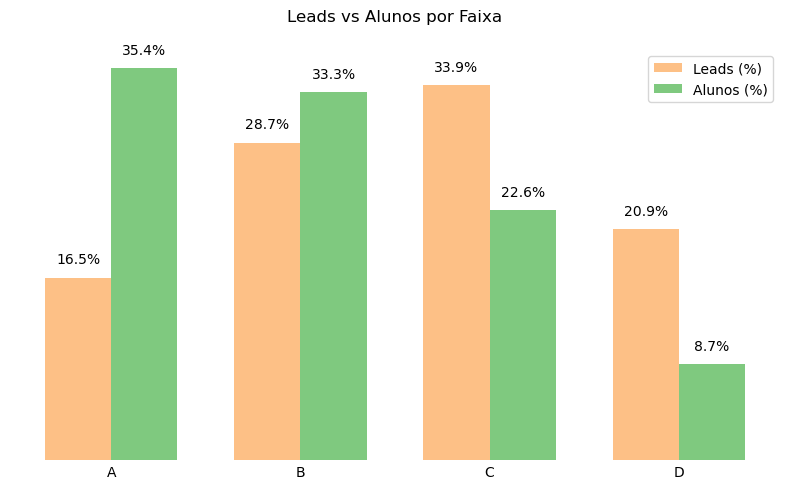

In [21]:
plot_comparativo_leads_alunos(df_leads, df_alunos)

In [22]:
# 1. Contagem por faixa
contagem = (
    df_leads.groupby(["lancamentos", "leadscore_faixa"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)
media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


A  A (%)     B  B (%)     C  C (%)     D  D (%)  \
lancamentos                                                       
SSP-L12      4378   16.7  7589   28.9  8865   33.8  5421   20.6   
SSP-L13       191   13.1   366   25.2   516   35.5   381   26.2   

             leadscore_medio  
lancamentos                   
SSP-L12               338.20  
SSP-L13               321.37

In [23]:
# 1. Contagem por faixa
contagem = (
    df_alunos.groupby(["lancamentos", "leadscore_faixa"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)

media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


A  A (%)     B  B (%)     C  C (%)     D  D (%)  \
lancamentos                                                       
SSP-L12      69.0   35.4  65.0   33.3  44.0   22.6  17.0    8.7   
SSP-L13       NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN   

             leadscore_medio  
lancamentos                   
SSP-L12               338.20  
SSP-L13               321.37

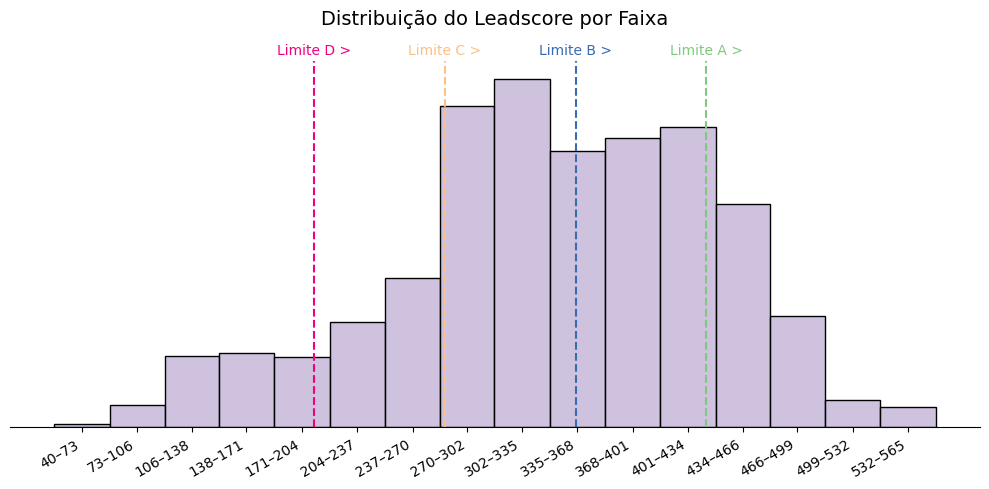

In [24]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

In [25]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["leadscore_faixa"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 12524
Desses, já compraram: 134
Ainda não compraram: 12390


In [26]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

# One-hot encoding
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelo
modelo_class = GradientBoostingClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

# Avaliação
roc_auc = roc_auc_score(y_test, modelo_class.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

# (Opcional) Score de probabilidade
df_leads["probabilidade_conversao_modelo"] = modelo_class.predict_proba(X)[:, 1]

ROC AUC (possível comprador): 0.661


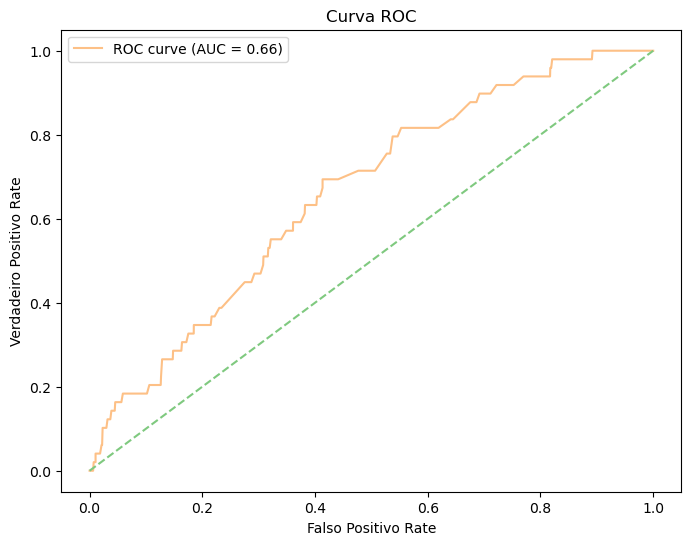

Threshold  Precision  Recall  F1 Score
1    0.020408      0.023   0.143     0.039
2    0.040816      0.024   0.041     0.030
3    0.061224      0.018   0.020     0.019
0    0.000000      0.007   1.000     0.014
48   0.979592      0.000   0.000     0.000
47   0.959184      0.000   0.000     0.000
28   0.571429      0.000   0.000     0.000
29   0.591837      0.000   0.000     0.000
30   0.612245      0.000   0.000     0.000
31   0.632653      0.000   0.000     0.000

In [27]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo_class.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [28]:
"""
Você poderá usar esse modelo para prever o score mesmo para leads que não constam no score_map ou para variáveis novas.
Também ajuda a testar consistência entre o modelo treinado e o score heurístico que você aplicou com base nos lifts.
"""

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_mapeado"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred_r = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
mae_pct = (mae / y_test_r.mean()) * 100

print(f"R² (leadscore_mapeado): {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")
print(f"MAE percentual: {mae_pct:.2f}%")

R² (leadscore_mapeado): 0.98
Erro médio absoluto (MAE): 9.16
MAE percentual: 2.23%


In [29]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_regressao"] = modelo_reg.predict(X_leads).round(2)

# Visualizar os top leads por score estimado
df_leads.drop(columns=['email']).head(10)

data  idade     nível  \
0  2025-04-07 0:00:00  38-45   Técnica   
1  2025-04-07 0:00:00  38-45   Técnica   
2  2025-04-07 0:00:00  28-32   Técnica   
3  2025-04-07 0:00:00  18-22   Técnica   
4  2025-04-07 0:00:00  23-27   Técnica   
5  2025-04-07 0:00:00  23-27   Técnica   
6  2025-04-07 0:00:00  33-37  Superior   
7  2025-04-07 0:00:00  23-27  Superior   
8  2025-04-07 0:00:00  23-27  Superior   
9  2025-04-07 0:00:00  38-45   Técnica   

                               situação profissional                  renda  \
0  Já sou funcionário terceirizado do sistema Pet...       De 3.000 a 5.000   
1                                    Desempregado(a)  Estou desempregado(a)   
2                                Funcionário público       De 1.000 a 3.000   
3                                    Desempregado(a)  Estou desempregado(a)   
4                                    Desempregado(a)       De 1.000 a 3.000   
5                     Funcionário de empresa privada       De 1.000 a 3.000   
6                     Funcionário de empresa privada       De 1.000 a 3.000   
7                     Funcionário de empresa privada       De 1.000 a 3.000   
8                     Funcionário de empresa privada       De 1.000 a 3.000   
9                     Funcionário de empresa privada       De 1.000 a 3.000   

                 escolaridade  \
0      Nível técnico completo   
1      Nível técnico completo   
2       Ensino médio completo   
3       Ensino médio completo   
4       Ensino médio completo   
5      Nível técnico completo   
6  Ensino superior incompleto   
7  Ensino superior incompleto   
8       Ensino médio completo   
9      Nível técnico completo   

                                              duvida  \
0              Como participar do processo seletivo    
1               Assunto específico que cai na prova?   
2                                     Nas perguntas    
3                                       Como estudar   
4                               Qual tempo de curso    
5  Como conseguir fazer a prova pra entrar na Pet...   
6                            O que vai cair na prova   
7     Como iniciar e o que é necessário para isso !    
8                             Como vou ser aprovado    
9                              Que a idade não ajuda   

                                         dificuldade lancamentos  \
0                                             Tempo      SSP-L12   
1                           Dificuldade em aprender!     SSP-L12   
2                                      Concentração      SSP-L12   
3                                        Constância      SSP-L12   
4                                           Nenhuma      SSP-L12   
5                                 Falta de notebook      SSP-L12   
6  Saber o assunto quando eu sei o assunto eu dom...     SSP-L12   
7                                             Tempo      SSP-L12   
8                                              Tempo     SSP-L12   
9                         Concentração e tempo livre     SSP-L12   

     utm_source                                       utm_campaign  \
0  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
1  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...   
2                                                                    
3  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
4  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
5  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
6                                                                    
7  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
8  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...   
9  Facebook-Ads  SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...   

                                    utm_medium               utm_content  \
0  00 | AUTO | LAL | 1%  | ENVOLVIMENTO IG 14D  ADS_006_ANUNCIO PETRO 06   
1               00 | AUTO | ENV

In [30]:
# Validar se o modelo de regressão estima bem as faixas reais dos alunos

# 1. Copiar info de score real e faixa real
df_avaliacao = df_alunos[["email", "leadscore_mapeado", "leadscore_faixa"]].copy()

# 2. Gerar os X para regressão (features iguais às usadas no modelo)
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

# 3. Aplicar o modelo de regressão
df_avaliacao["leadscore_regressao"] = modelo_reg.predict(X_alunos)

# 4. Classificar usando a função baseada na média dos alunos
df_avaliacao["faixa_regressao"] = df_avaliacao["leadscore_regressao"].apply(classificar_faixa)

# 5. Ver a matriz de confusão real x predita
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao   A   B   C   D
leadscore_faixa                
A                67   2   0   0
B                 0  64   1   0
C                 0   3  41   0
D                 0   0   0  17

In [31]:
# Juntar as bases
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Convertendo para string para evitar erro de comparação entre categoricals com categorias diferentes
        diferentes = (comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)).sum()
        total = comparacao.shape[0]
        mudancas[var] = round((diferentes / total) * 100, 1)
    else:
        mudancas[var] = None  # Ou 0, ou continue

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas = df_mudancas.dropna().sort_values(by="% Respostas Diferentes", ascending=False)

df_mudancas

% Respostas Diferentes
renda                                     0.0
escolaridade                              0.0
idade                                     0.0
nível                                     0.0
situação profissional                     0.0

In [32]:
# Para cada variável comum, mostrar diferenças
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Comparação como string para evitar erros com categorias
        diferentes = comparacao[comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)]
        total = comparacao.shape[0]

        print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
        display(diferentes[["email", col_lead, col_aluno]].head(10))
    else:
        print(f"\n⚠️ Coluna '{var}' não encontrada em ambos os DataFrames.")


🔍 0 de 195 respostas são diferentes em 'renda'


Empty DataFrame
Columns: [email, renda_lead, renda_aluno]
Index: []


🔍 0 de 195 respostas são diferentes em 'escolaridade'


Empty DataFrame
Columns: [email, escolaridade_lead, escolaridade_aluno]
Index: []


🔍 0 de 195 respostas são diferentes em 'idade'


Empty DataFrame
Columns: [email, idade_lead, idade_aluno]
Index: []


🔍 0 de 195 respostas são diferentes em 'nível'


Empty DataFrame
Columns: [email, nível_lead, nível_aluno]
Index: []


🔍 0 de 195 respostas são diferentes em 'situação profissional'


Empty DataFrame
Columns: [email, situação profissional_lead, situação profissional_aluno]
Index: []

In [33]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_mapeado"] = df_leads["leadscore_mapeado"]  # Adiciona o score final como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_modelo"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.5999875379055373
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      6878
           1       0.01      0.45      0.02        49

    accuracy                           0.74      6927
   macro avg       0.50      0.59      0.44      6927
weighted avg       0.99      0.74      0.84      6927



In [34]:
# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dois componentes separadamente
leadscore_normalizado = scaler.fit_transform(df_leads[["leadscore_regressao"]]).flatten()
probabilidade_normalizada = scaler.fit_transform(df_leads[["probabilidade_conversao_modelo"]]).flatten()

# Pesos (ajustáveis)
peso_score = 0.5
peso_prob = 0.5

# Calcular o score híbrido como média ponderada dos valores normalizados
df_leads["score_hibrido"] = (
    peso_score * leadscore_normalizado +
    peso_prob * probabilidade_normalizada
).round(4)

# Opcional: ordenar para inspeção
df_leads = df_leads.sort_values("score_hibrido", ascending=False)

# Exibir os 10 primeiros leads rankeados
display(df_leads[["email", "leadscore_regressao", "leadscore_faixa", "probabilidade_conversao_modelo", "score_hibrido"]].drop(columns=['email']).head(10))

leadscore_regressao leadscore_faixa  probabilidade_conversao_modelo  \
22683               515.93               A                        0.890166   
23396               515.93               A                        0.890166   
8826                515.93               A                        0.890166   
1226                513.69               A                        0.879082   
1015                513.69               A                        0.879082   
5011                513.69               A                        0.879082   
17903               513.69               A                        0.879082   
3070                513.69               A                        0.879082   
24889               513.69               A                        0.879082   
15893               513.69               A                        0.879082   

       score_hibrido  
22683         0.9674  
23396         0.9674  
8826          0.9674  
1226          0.9589  
1015          0.9589  
5011          0.9589  
17903         0.9589  
3070          0.9589  
24889         0.9589  
15893         0.9589

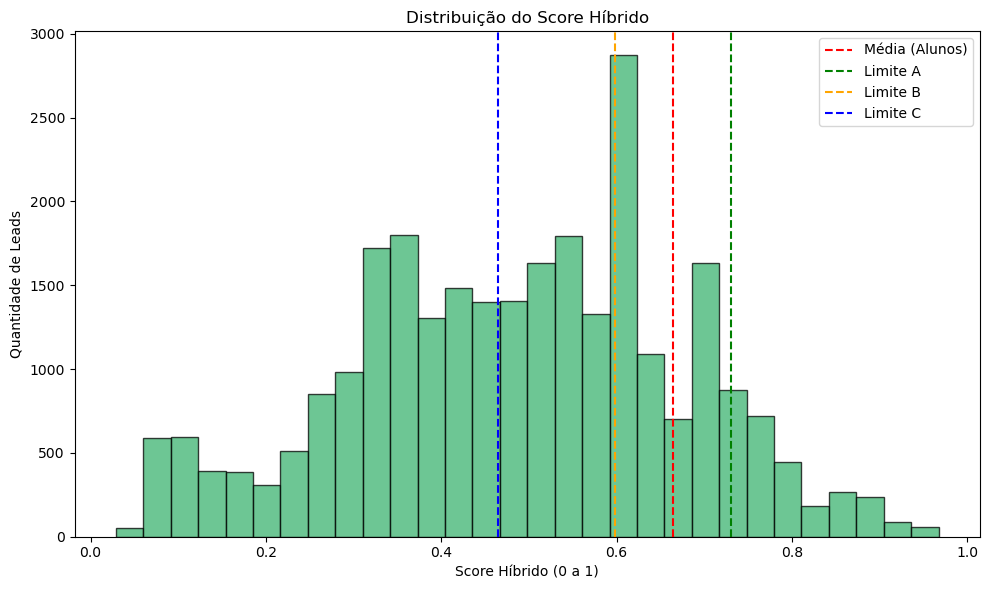

Total Leads  Alunos Taxa de Conversão (%)
faixa_score_hibrido                                           
A                           2543      73                  2.9%
B                           6354      60                  0.9%
C                           7014      39                  0.6%
D                          11796      23                  0.2%

In [35]:
# Base de referência: score_hibrido dos ALUNOS
media_hibrido_alunos = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean()

# Limiares baseados na média dos alunos
limite_A = media_hibrido_alunos * 1.10
limite_B = media_hibrido_alunos * 0.90
limite_C = media_hibrido_alunos * 0.70

# Função de classificação
def classificar_faixa_hibrida(score):
    if score >= limite_A:
        return "A"
    elif score >= limite_B:
        return "B"
    elif score >= limite_C:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_hibrida)

# Plotar histograma do score_hibrido
plt.figure(figsize=(10, 6))
plt.hist(df_leads["score_hibrido"], bins=30, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(media_hibrido_alunos, color="red", linestyle="--", label="Média (Alunos)")
plt.axvline(limite_A, color="green", linestyle="--", label="Limite A")
plt.axvline(limite_B, color="orange", linestyle="--", label="Limite B")
plt.axvline(limite_C, color="blue", linestyle="--", label="Limite C")

plt.title("Distribuição do Score Híbrido")
plt.xlabel("Score Híbrido (0 a 1)")
plt.ylabel("Quantidade de Leads")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Gerar tabela de faixas com base na nova coluna faixa_score_hibrido
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar a taxa de conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (
    tabela_faixas_hibrido["Taxa de Conversão"] * 100
).round(1).astype(str) + "%"

# Opcional: remover coluna bruta
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir resultado
display(tabela_faixas_hibrido)

In [36]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos", observed=True)["score_hibrido"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"score_hibrido": "Probabilidade Relativa (0 - 1)"})
)

display(media_hibrido_por_lancamento)

lancamentos  Probabilidade Relativa (0 - 1)
0     SSP-L12                            0.49
1     SSP-L13                            0.45

In [37]:
# Agrupamento por lançamento
tabela_lancamentos_avancada = df_leads.groupby("lancamentos", observed=True).agg(
    total_leads=("email", "count"),
    compras_reais=("comprou", "sum"),
    score_hibrido_medio=("score_hibrido", "mean"),
    probabilidade_media_modelo=("probabilidade_conversao_modelo", "mean"),
    taxa_real_conversao=("comprou", "mean")  # 0 = não comprou, 1 = comprou
).reset_index()

# Formatando colunas
tabela_lancamentos_avancada["score_hibrido_medio"] = tabela_lancamentos_avancada["score_hibrido_medio"].round(2)
tabela_lancamentos_avancada["probabilidade_media_modelo"] = (tabela_lancamentos_avancada["probabilidade_media_modelo"]).round(2)
tabela_lancamentos_avancada["taxa_real_conversao (%)"] = (tabela_lancamentos_avancada["taxa_real_conversao"] * 100).round(2)

# Selecionar colunas finais
tabela_lancamentos_avancada = tabela_lancamentos_avancada[[
    "lancamentos",
    "total_leads",
    "compras_reais",
    "taxa_real_conversao (%)",
    "probabilidade_media_modelo",
    "score_hibrido_medio"
]]

# Exibir resultado
display(tabela_lancamentos_avancada)

lancamentos  total_leads  compras_reais  taxa_real_conversao (%)  \
0     SSP-L12        26253            194                     0.74   
1     SSP-L13         1454              1                     0.07   

   probabilidade_media_modelo  score_hibrido_medio  
0                        0.36                 0.49  
1                        0.32                 0.45

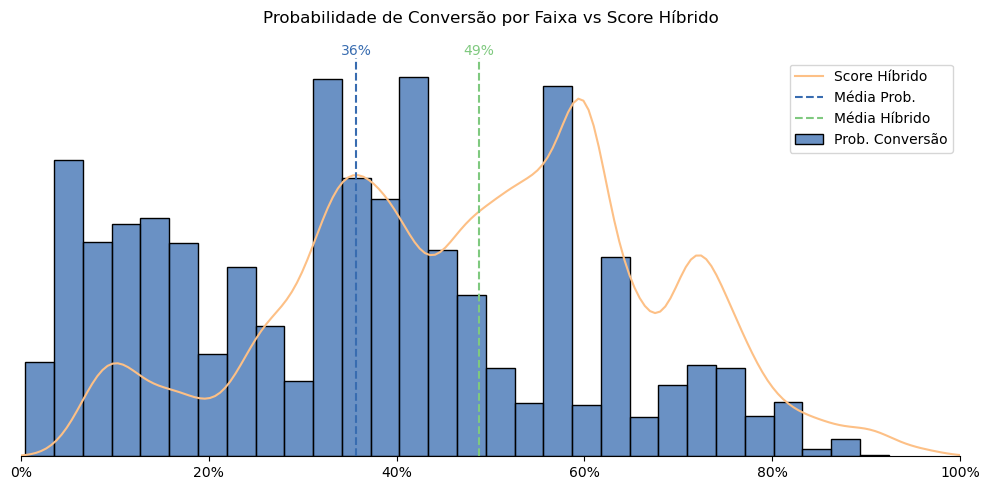

In [38]:
plot_probabilidade_conversao_vs_score(df_leads)

In [39]:
# Gerar a tabela cruzada real x predita com leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada: faixa real (aluno) vs faixa predita (modelo híbrido)
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])

# Calcular Cramér’s V com essa matriz
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calcular e imprimir
cramers_v_score = cramers_v(comparativo_faixa)
print(f"Cramér’s V: {cramers_v_score:.3f} (0 = sem associação, 1 = associação perfeita)")

Cramér’s V: 0.448 (0 = sem associação, 1 = associação perfeita)


In [40]:
# Caminho direto para a pasta 'modelos'
path_modelos = Path("C:/Users/Camilo_Bica/data_science/consultoria/acelerador_petrobras/modelos")
path_modelos.mkdir(parents=True, exist_ok=True)

# Média dos compradores (referência para benchmarking)
media_compradores = df_alunos["leadscore_mapeado"].mean()

# 1. Modelo de regressão para prever leadscore
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

# 2. Limites para classificar em faixas A, B, C, D
limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

joblib.dump(score_map, path_modelos / "score_map.pkl")

# 3. Modelo de classificação calibrado para prever conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

tabelas_lift = {}
for feature in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, feature)
    tabelas_lift[feature] = tabela

joblib.dump(tabelas_lift, path_modelos / "tabelas_lift.pkl")

# 4. Confirmação
print("✅ Modelos e arquivos de configuração exportados para:", path_modelos)

✅ Modelos e arquivos de configuração exportados para: C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\modelos


In [41]:
from gspread_dataframe import set_with_dataframe
from datetime import datetime

# Carrega as variáveis de ambiente
load_dotenv()

# Pega o caminho de forma segura
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")

# === Escopos de acesso ===
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

# === Autenticar ===
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para criar nova planilha e carregar dados ===
def criar_planilha_e_enviar(df, nome_base):
    nome_final = nome_base
    
    # Cria nova planilha
    planilha = client.create(nome_final)
    
    # Compartilha com seu e-mail pessoal (aqui você coloca o seu)
    planilha.share('camilobf2@gmail.com', perm_type='user', role='writer')  # <<< Trocar pelo seu email do Gmail

    # Preenche a primeira aba
    aba = planilha.sheet1
    aba.update_title("Dados")
    set_with_dataframe(aba, df)
    
    print(f"✅ Nova planilha criada: {nome_final}")
    print(f"🔗 Link: https://docs.google.com/spreadsheets/d/{planilha.id}/edit")

# === Geração dos arquivos ===
#criar_planilha_e_enviar(df_alunos, "leadscore_implementado")

In [42]:
# === Função para atualizar uma planilha existente ===
def atualizar_planilha_existente(df: pd.DataFrame, sheet_id: str, aba_nome: str = "Dados"):
    """
    Atualiza uma aba específica de uma planilha no Google Sheets.
    
    - df: DataFrame com os dados que serão enviados
    - sheet_id: ID da planilha (o que vem na URL depois de "/d/")
    - aba_nome: Nome da aba que será atualizada (default: 'Dados')
    """
    try:
        planilha = client.open_by_key(sheet_id)
        try:
            aba = planilha.worksheet(aba_nome)
        except gspread.WorksheetNotFound:
            aba = planilha.add_worksheet(title=aba_nome, rows="1000", cols="20")
        
        aba.clear()  # Limpa dados antigos
        set_with_dataframe(aba, df)
        
        print(f"✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/{sheet_id}/edit")
    except Exception as e:
        print(f"❌ Erro ao atualizar a planilha: {e}")

# === IDs das planilhas (FIXOS, preencha certinho aqui) ===
id_leads = "1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc"
id_alunos = "15RQf1wkiafPZftolCIAwcTFE7rv0_zRTB0zDOCkdPRs"

# === Atualizar todas as planilhas ===
atualizar_planilha_existente(df_leads, id_leads)
atualizar_planilha_existente(df_alunos, id_alunos)

✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc/edit
✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/15RQf1wkiafPZftolCIAwcTFE7rv0_zRTB0zDOCkdPRs/edit
